In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import time
import math
import matplotlib.pyplot as plt

import EnergyPricesLibrary as Ep

from kerastuner.tuners import BayesianOptimization
from sklearn.metrics import mean_squared_error

%load_ext autoreload
%autoreload 2

In [29]:
def build_model(hourly_input_shape,daily_input_shape,image_input_shape):
    
    input_1 = tf.keras.layers.Input(shape=hourly_input_shape)
    input_2 = tf.keras.layers.Input(shape=daily_input_shape)
    input_3 = tf.keras.layers.Input(shape=image_input_shape)
    
    model_1_1 = tf.keras.layers.LSTM(
        units=512,
        activation='tanh',
        kernel_regularizer=tf.keras.regularizers.L1(l1=0),
        dropout=0,
        return_sequences=True
    )(input_1)
    model_1_1 = tf.keras.layers.LSTM(
        units=64,
        activation='tanh',
        kernel_regularizer=tf.keras.regularizers.L1(l1=0.105),
        dropout=0.99,
        return_sequences=True
    )(model_1_1)
    model_1_1 = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(units=120,activation='relu')
    )(model_1_1)
    model_1_1 = tf.keras.layers.Dropout(rate=0)(model_1_1)
    model_1_1 = tf.keras.layers.Flatten()(model_1_1)
    model_1_1 = tf.keras.layers.Dense(units=24,activation=None)(model_1_1)

    model_2_2 = tf.keras.layers.LSTM(
            units=512,
            activation='tanh',
            kernel_regularizer=tf.keras.regularizers.L1(l1=0),
            dropout=0.54,
            return_sequences=False
    )(input_2)
    model_2_2 = tf.keras.layers.Dense(units=24,activation=None)(model_2_2)

    model_3 = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Conv2D(
            filters=44,
            kernel_size=3,
            activation='relu',
            padding='valid'
        )
    )(input_3)

    model_3 = tf.keras.layers.TimeDistributed(tf.keras.layers.AveragePooling2D(pool_size=3))(model_3)
    model_3 = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Conv2D(
            filters=20,
            kernel_size=7,
            activation='relu',
            padding='valid'
        )
    )(model_3)
    model_3 = tf.keras.layers.TimeDistributed(tf.keras.layers.AveragePooling2D(pool_size=3))(model_3)
    model_3 = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(model_3)
    model_3 = tf.keras.layers.LSTM(
            units=64,
            activation='tanh',
            kernel_regularizer=tf.keras.regularizers.L1(l1=0.0075),
            dropout=0.09,
            return_sequences=False,
            stateful=False
    )(model_3)
    model_3 = tf.keras.layers.Dense(units=24,activation=None)(model_3)

    output = tf.keras.layers.Add()([model_1_1, model_2_2, model_3])
    full_model = tf.keras.Model(inputs=[input_1, input_2, input_3], outputs=[output])
    
    return full_model

def make_predictions(model,scaler_D_x,scaler_D_y,scaler_H_x,scaler_H_y,
                     trainX_D, trainY_D, testX_D, testY_D,
                     trainX_H, trainY_H, testX_H, testY_H,
                     trainX_I, trainY_I, testX_I, testY_I,
                     n_steps_out,len_output_features):
    
    # make predictions
    trainPredict = model.predict([trainX_H,trainX_D,trainX_I])
    trainPredict = trainPredict.reshape(trainPredict.shape[0]*n_steps_out,len_output_features)
    testPredict  = model.predict([testX_H,testX_D,testX_I])
    testPredict  = testPredict.reshape(testPredict.shape[0]*n_steps_out,len_output_features)
    
    # invert predictions
    trainPredict = scaler_D_y.inverse_transform(trainPredict)
    trainY = scaler_D_y.inverse_transform(trainY_D.reshape(trainY_D.shape[0]*n_steps_out,len_output_features))
    
    testPredict = scaler_D_y.inverse_transform(testPredict)
    testY = scaler_D_y.inverse_transform(testY_D.reshape(testY_D.shape[0]*n_steps_out,len_output_features))
        
    return trainPredict,trainY,testPredict,testY

def get_metrics(trainY,trainPredict,testY,testPredict):
    
    trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
    trainMAPE  = Ep.MAPE(trainPredict,trainY)
    print('Train Score: %.2f RMSE' % trainScore)
    print('Train Score: %.2f MAPE' % trainMAPE)

    testScore = math.sqrt(mean_squared_error(testY, testPredict))
    testMAPE  = Ep.MAPE(testPredict,testY)
    print('Test Score: %.2f RMSE' % testScore)
    print('Test Score: %.2f MAPE' % testMAPE)
    
    return trainScore,trainMAPE,testScore,testMAPE

In [3]:
data_diaria_path = os.path.join('dataset','Series','Sabanas','Original','Sabana_Datos_Diaria.xlsx')
data_diaria = pd.read_excel(data_diaria_path)
data_diaria = data_diaria.set_index('Fecha')

In [4]:
data_horaria_path = os.path.join('dataset','Series','Sabanas','Original','Sabana_Datos_Horaria.xlsx')
data_horaria = pd.read_excel(data_horaria_path)
data_horaria = data_horaria.set_index('Fecha')

In [5]:
climatic_images_prcp_dir = os.path.join('dataset','Climatic Images','PRCP')
climatic_images_tavg_dir = os.path.join('dataset','Climatic Images','TAVG')

In [6]:
precio_bolsa_path = os.path.join('dataset','Series','Sabanas','Original','Sabana_Datos_Precio_Bolsa.xlsx')
precio_bolsa = pd.read_excel(precio_bolsa_path)
precio_bolsa = precio_bolsa.set_index('Fecha')

In [7]:
nombre_series_diaria = data_diaria.columns.values
nombre_series_horaria = data_horaria.columns.values

In [8]:
data_horaria_full = pd.concat([data_horaria,precio_bolsa],axis=1)

In [9]:
data_horaria.shape,data_diaria.shape, precio_bolsa.shape

((176760, 84), (7365, 119), (176760, 1))

## Build Window

In [10]:
lista_fechas = list()
lista_rutas = list()
for prcp_file,tavg_file in zip(os.listdir(climatic_images_prcp_dir),os.listdir(climatic_images_tavg_dir)):
    fecha = prcp_file.split('.')[0]
    ruta_prcp = os.path.join(climatic_images_prcp_dir,prcp_file)
    ruta_tavg = os.path.join(climatic_images_tavg_dir,tavg_file)
    lista_fechas.append(fecha)
    lista_rutas.append([ruta_prcp,ruta_tavg])

In [11]:
dataset_df = pd.DataFrame(lista_rutas,index=lista_fechas,columns=['Precipitacion','Temperatura'])

TimeSplit_down = '2000-02-01'
TimeSplit_middle = '2020-01-01'
TimeSplit_top = '2020-03-31'
n_steps_out = 24 
n_steps_in  = 3
overlap = 1

In [12]:
output_features = ['$kWh']
len_output_features = len(output_features)

IMG_HEIGHT,IMG_WIDTH = 128,128

trainX_I, trainY_I, testX_I, testY_I, scaler_y_I, dataset_x_I, dataset_y_I = Ep.SplitTimeseriesMultipleTimesBackAhead_DifferentTimes_Images(
    df_x=dataset_df,
    df_y=precio_bolsa,
    TimeSplit_down=TimeSplit_down,
    TimeSplit_middle=TimeSplit_middle,
    TimeSplit_top=TimeSplit_top,
    n_steps_out=n_steps_out,
    n_steps_in=n_steps_in,
    overlap=overlap,
    output_features=output_features,
    IMG_HEIGHT=IMG_HEIGHT,
    IMG_WIDTH=IMG_WIDTH)

trainX_I.shape, trainY_I.shape, testX_I.shape, testY_I.shape

((7271, 3, 128, 128, 6), (7271, 24, 1), (91, 3, 128, 128, 6), (91, 24, 1))

In [13]:
d = 'All'
time_split = '2020-01-01'
n_steps_out=24
output_columns = ['$kWh']

In [14]:
n_steps_in = 3
overlap = 1
inputs_columns = nombre_series_diaria

len_input_features = len(inputs_columns)
len_output_features = len(output_columns)

trainX_D, trainY_D, testX_D, testY_D, scaler_D_x,scaler_D_y, dataset_x_D, dataset_y_D = Ep.SplitTimeseriesMultipleTimesBackAhead_differentTimes(
    df_x=data_diaria,
    df_y=precio_bolsa,
    day = d, 
    TimeSplit = time_split,
    n_steps_out=n_steps_out,
    n_steps_in =n_steps_in, 
    overlap = overlap,
    input_features=inputs_columns,
    output_features=output_columns)

In [15]:
n_steps_in = 72
overlap = 24
inputs_columns = nombre_series_horaria

len_input_features = len(inputs_columns)
len_output_features = len(output_columns)

trainX_H, trainY_H, testX_H, testY_H, scaler_H_x,scaler_H_y, df2_H, dataset_H = Ep.SplitTimeseriesMultipleTimesBackAhead(data_horaria_full,
                                                                                              day = d, 
                                                                                              ValData = 'index', 
                                                                                              TimeAhead = time_split, 
                                                                                              n_steps_out= n_steps_out, 
                                                                                              n_steps_in = n_steps_in, 
                                                                                              overlap = overlap,
                                                                                              input_features=inputs_columns,
                                                                                              output_features=output_columns)

In [16]:
print('Data Diaria')
trainX_D.shape, trainY_D.shape, testX_D.shape, testY_D.shape

Data Diaria


((7271, 3, 119), (7271, 24, 1), (91, 3, 119), (91, 24, 1))

In [17]:
print('Data Horaria')
trainX_H.shape, trainY_H.shape, testX_H.shape, testY_H.shape

Data Horaria


((7271, 72, 84), (7271, 24, 1), (91, 72, 84), (91, 24, 1))

In [18]:
print('Data Imagenes')
trainX_I.shape, trainY_I.shape, testX_I.shape, testY_I.shape

Data Imagenes


((7271, 3, 128, 128, 6), (7271, 24, 1), (91, 3, 128, 128, 6), (91, 24, 1))

## Model

In [19]:
callback_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                          factor=0.1,
                                                          min_lr=1e-5,
                                                          patience=0,
                                                          verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=5,
                                                  mode='min')

callbacks = [callback_reduce_lr,early_stopping]

In [20]:
hourly_input_shape = (trainX_H.shape[1],trainX_H.shape[2])
daily_input_shape = (trainX_D.shape[1],trainX_D.shape[2])
images_input_shape = trainX_I[0].shape

model = build_model(hourly_input_shape,daily_input_shape,images_input_shape)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 3, 128, 128, 0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 72, 84)]     0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 3, 126, 126,  2420        input_3[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 72, 512)      1222656     input_1[0][0]                    
_______________________________________________________________________________________

In [21]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              loss=tf.losses.MeanSquaredError(),
              metrics=[tf.metrics.MeanAbsoluteError(),
                       tf.keras.metrics.MeanAbsolutePercentageError()])

In [22]:
import json

model_json = model.to_json()
with open("Model_Full.json", "w") as json_file:
    json_file.write(model_json)

In [23]:
model.fit([trainX_H,trainX_D,trainX_I], trainY_D, validation_data=([testX_H,testX_D,testX_I],testY_D),
               epochs=200,callbacks=callbacks,verbose=1)

Epoch 1/200
228/228 [==============================] - 39s 170ms/step - loss: 536.9151 - mean_absolute_error: 0.0608 - mean_absolute_percentage_error: 8181.9995 - val_loss: 364.4561 - val_mean_absolute_error: 0.1357 - val_mean_absolute_percentage_error: 122.7594
Epoch 2/200
228/228 [==============================] - 36s 157ms/step - loss: 242.7785 - mean_absolute_error: 0.0272 - mean_absolute_percentage_error: 3607.5752 - val_loss: 143.5310 - val_mean_absolute_error: 0.0957 - val_mean_absolute_percentage_error: 89.8029
Epoch 3/200
228/228 [==============================] - 36s 158ms/step - loss: 80.9930 - mean_absolute_error: 0.0177 - mean_absolute_percentage_error: 2554.0269 - val_loss: 31.3067 - val_mean_absolute_error: 0.0333 - val_mean_absolute_percentage_error: 31.1862
Epoch 4/200
228/228 [==============================] - 36s 158ms/step - loss: 9.4503 - mean_absolute_error: 0.0165 - mean_absolute_percentage_error: 2057.0896 - val_loss: 0.2550 - val_mean_absolute_error: 0.0300 - v

In [25]:
model.evaluate(x=[testX_H,testX_D,testX_I], y=testY_D)

3/3 [==============================] - 0s 32ms/step - loss: 0.0244 - mean_absolute_error: 0.0266 - mean_absolute_percentage_error: 22.8576


[0.024413475766777992, 0.02662394382059574, 22.857568740844727]

In [26]:
trainPredict,trainY,testPredict,testY = make_predictions(model,scaler_D_x,scaler_D_y,scaler_H_x,scaler_H_y,
                                                         trainX_D, trainY_D, testX_D, testY_D,
                                                         trainX_H, trainY_H, testX_H, testY_H,
                                                         trainX_I, trainY_I, testX_I, testY_I,
                                                         n_steps_out,len_output_features)

In [27]:
trainPredict.shape,trainY.shape,testPredict.shape,testY.shape

((174504, 1), (174504, 1), (2184, 1), (2184, 1))

In [30]:
trainScore,trainMAPE,testScore,testMAPE = get_metrics(trainY,trainPredict,testY,testPredict)

Train Score: 82.26 RMSE
Train Score: 0.30 MAPE
Test Score: 97.76 RMSE
Test Score: 0.21 MAPE


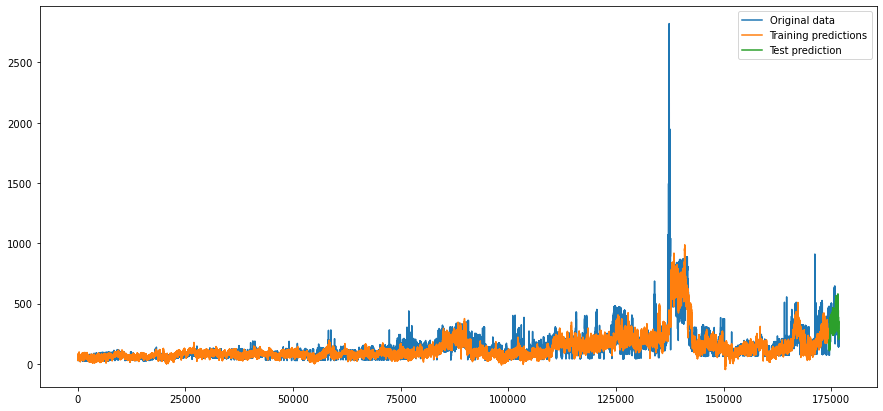

In [31]:
Nt = trainPredict.shape[0] + testPredict.shape[0]
trainPredictPlot = np.zeros((Nt,1))
trainPredictPlot[:,:] = np.nan
trainPredictPlot[:len(trainPredict), :] = np.concatenate((dataset_y_D[0].reshape(1,1),trainPredict[:-1]))

# shift test predictions for plotting
testPredictPlot = np.zeros((Nt,1))
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict):Nt, :] = testPredict

plt.figure(figsize=(15,7))
plt.plot(np.concatenate((trainY,testY)),label='Original data')
plt.plot(trainPredictPlot,label='Training predictions')
plt.plot(testPredictPlot,label='Test prediction')
plt.legend()
plt.show()

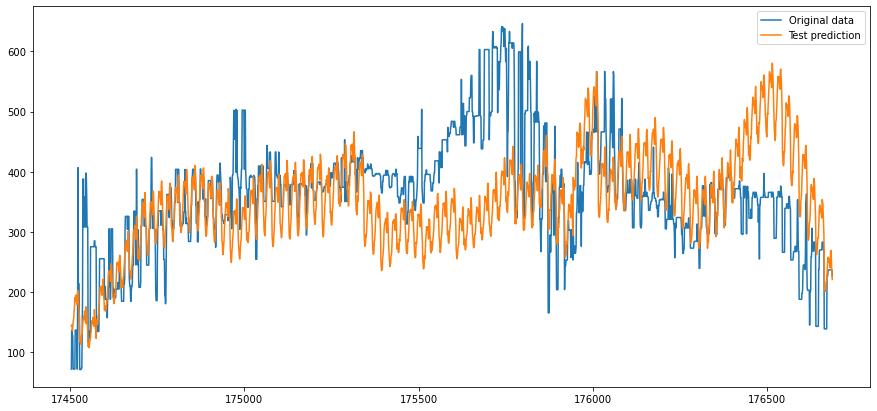

In [32]:
# shift test predictions for plotting
testOriginalPlot = np.zeros((Nt,1))
testOriginalPlot[:, :] = np.nan
testOriginalPlot[len(trainPredict):Nt, :] = testY

# shift test predictions for plotting
testPredictPlot = np.zeros((Nt,1))
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict):Nt, :] = testPredict

plt.figure(figsize=(15,7))
plt.plot(testOriginalPlot,label='Original data')
plt.plot(testPredictPlot,label='Test prediction')
plt.legend()
plt.show()